# HOLStep Dataset Intermediate Proof Step Data Transformation and Model Training Notebook

## Importing All Necessary Packages

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

## Load the data to a Pandas DataFrame from the modified master dataset; includes all test and training samples as provided by the authors of the HOLStep paper

In [85]:
my_dir = 'G:\\'
df = pd.read_csv(my_dir + 'master.txt', delimiter=';')

## Remove all dependency steps from the dataset to include only intermediate proof steps

In [86]:
intermed_only = df['depen_bin'] == 0
df_intermed_only = df[intermed_only]
df_intermed_only = df_intermed_only[['step_token', 'useful_bin']]

## Transform the intermediate proof step text tokenization to vectors representing the text using CountVectorizer(), then transform to TFIDF format to limit the importance of common stop tokens

In [87]:
step_vectorizer = CountVectorizer()
vectorized_tokens = step_vectorizer.fit_transform(df_intermed_only['step_token'])

In [88]:
tfidf_transformer = TfidfTransformer()
tfidf_dataset = tfidf_transformer.fit_transform(vectorized_tokens)

## Split TFIDF dataset and usefulness indicator variable into 90% training and 10% test datasets

In [89]:
(X_train, X_test, y_train, y_test) = train_test_split(tfidf_dataset, df_intermed_only['useful_bin'], test_size=0.1, random_state=2018)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1988168, 1944)
(220908, 1944)
(1988168,)
(220908,)


## Confirm balance of training and test datasets

In [90]:
print(y_train.loc[y_train == 1].count())
print(y_train.loc[y_train == 0].count())
print(y_test.loc[y_test == 1].count())
print(y_test.loc[y_test == 0].count())

994304
993864
110234
110674


# Naive Bayes Classifier

## Fit the model

In [9]:
naiveb = BernoulliNB().fit(X_train, y_train)

In [10]:
naiveb

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Evaluate the model

In [12]:
pred_test = naiveb.predict(X_test)
pred_test_prob = naiveb.predict_proba(X_test)

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

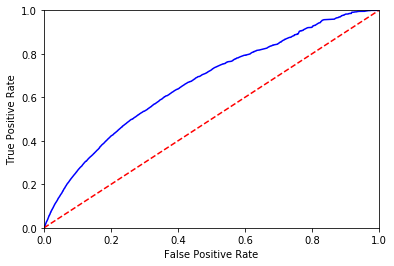

In [14]:
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
print('AUC', round(metrics.roc_auc_score(y_test, pred_test_prob[:,1]), 2))

AUC 0.67


In [16]:
print('Overall Accuracy', metrics.accuracy_score(y_test, pred_test))

Overall Accuracy 0.6196833070780596


# Logistic Regression

## Fit the model

In [18]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Evaluate the model

In [19]:
pred_test_lr = lr.predict(X_test)
pred_test_prob_lr = lr.predict_proba(X_test)

In [20]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, pred_test_prob_lr[:,1])
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

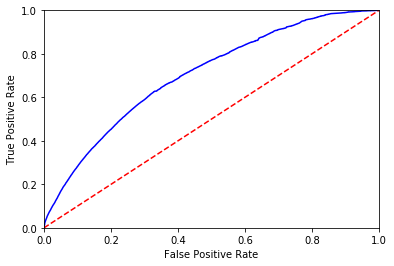

In [21]:
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [48]:
print('AUC', metrics.roc_auc_score(y_test, pred_test_prob_lr[:,1]))

AUC 0.7028307077899201


In [23]:
print('Overall Accuracy', metrics.accuracy_score(y_test, pred_test_lr))

Overall Accuracy 0.6471019609973383


# Random Forest Classifier

## Fit the model

In [24]:
randf = RandomForestClassifier(max_depth=4, random_state=2018, n_estimators=100)
randf = randf.fit(X_train, y_train)

In [25]:
randf.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       7.42780454e-04, 6.54113005e-05, 4.45279180e-02])

## Evaluate the model

In [26]:
pred_test_randf = randf.predict(X_test)
pred_test_prob_randf = randf.predict_proba(X_test)

In [27]:
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, pred_test_prob_randf[:,1])
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

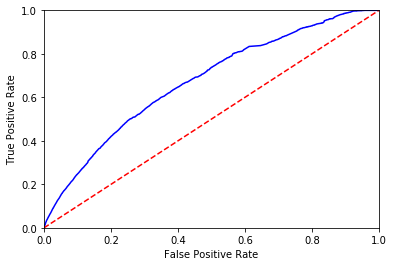

In [28]:
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC = %0.2f' % roc_auc_rf)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
metrics.roc_auc_score(y_test, pred_test_prob_randf[:,1])

0.6733965345226479

In [30]:
metrics.accuracy_score(y_test, pred_test_randf)

0.6241014358918645

# Gradient Boosting Machine

## Fit the model

In [31]:
gbm = GradientBoostingClassifier(max_depth=4, random_state=2018, n_estimators=100, verbose=1)
gbm = gbm.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3691           50.63m
         2           1.3547           50.57m
         3           1.3388           49.31m
         4           1.3258           48.59m
         5           1.3132           47.99m
         6           1.3045           47.57m
         7           1.2954           46.86m
         8           1.2877           46.19m
         9           1.2807           45.70m
        10           1.2749           45.28m
        20           1.2299           40.17m
        30           1.2090           35.22m
        40           1.1953           30.50m
        50           1.1835           25.52m
        60           1.1745           20.55m
        70           1.1683           15.49m
        80           1.1609           10.32m
        90           1.1533            5.16m
       100           1.1483            0.00s


## Evaluate the model

In [32]:
pred_test_gbm = gbm.predict(X_test)
pred_test_prob_gbm = gbm.predict_proba(X_test)

In [33]:
fpr_gbm, tpr_gbm, thresholds_gbm = metrics.roc_curve(y_test, pred_test_prob_gbm[:,1])
roc_auc_gbm = metrics.auc(fpr_gbm, tpr_gbm)

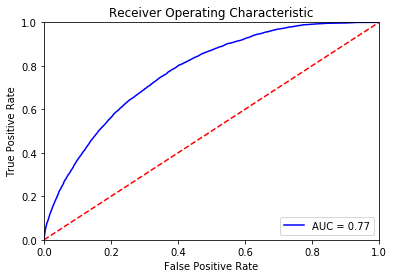

In [34]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gbm, tpr_gbm, 'b', label = 'AUC = %0.2f' % roc_auc_gbm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
metrics.roc_auc_score(y_test, pred_test_prob_gbm[:,1])

0.7739136916861643

In [36]:
metrics.accuracy_score(y_test, pred_test_gbm)

0.6989334926756839

# Logistic Regression tuning with GridSearchCV

## Tune the model

In [40]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=10)

## Fit the model

In [41]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
clf

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Evaluate the model

In [43]:
print(clf.best_score_)

0.6471012510009214


In [44]:
pred_test_gscvlr = clf.predict(X_test)
pred_test_prob_gscvlr = clf.predict_proba(X_test)

In [49]:
print('AUC', metrics.roc_auc_score(y_test, pred_test_prob_gscvlr[:,1]))

AUC 0.7033909417546919


In [46]:
print('Overall Accuracy', metrics.accuracy_score(y_test, pred_test_gscvlr))

Overall Accuracy 0.6478081373241349
